In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '16'

In [2]:
import pennylane as qml
import torchvision
import numpy as np
from pennylane.templates import RandomLayers
import torch
import matplotlib.pyplot as plt

# Setting of the main hyper-parameters of the model


In [3]:
n_epochs = 30   # Number of optimization epochs
n_layers = 5    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 50     # Size of the test dataset

np.random.seed(0)           # Seed for NumPy random number generator
torch.manual_seed(0)       # Seed for TensorFlow random number generator

# Loading of the MNIST dataset


In [4]:
def transform(x):
    x = np.array(x)
    x = x/255.0
    
    return torch.from_numpy(x).float()
train_set = torchvision.datasets.MNIST(root='./mnist', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./mnist', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64)


# Quantum circuit as a convolution kernel

We follow the scheme described in the introduction and represented in
the figure at the top of this demo.

We initialize a PennyLane `default.qubit` device, simulating a system of
$4$ qubits. The associated `qnode` represents the quantum circuit
consisting of:

1.  an embedding layer of local $R_y$ rotations (with angles scaled by a
    factor of $\pi$);
2.  a random circuit of `n_layers`;
3.  a final measurement in the computational basis, estimating $4$
    expectation values.


[[4.61936028 6.04560893 1.5629621  3.6201033  3.71990916 3.59556477]
 [1.40166324 5.98629859 2.80937161 5.31814253 4.39495791 1.86885148]]


/home/paultran27/miniconda3/envs/pnl_G/lib/python3.11/site-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/home/paultran27/miniconda3/envs/pnl_G/lib/python3.11/site-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


[tensor([0.5811, 0.5811, 0.5811]),
 tensor([0.0176, 0.0176, 0.0176]),
 tensor([-0.0546, -0.0546, -0.0546]),
 tensor([-0.2230, -0.2230, -0.2230])]

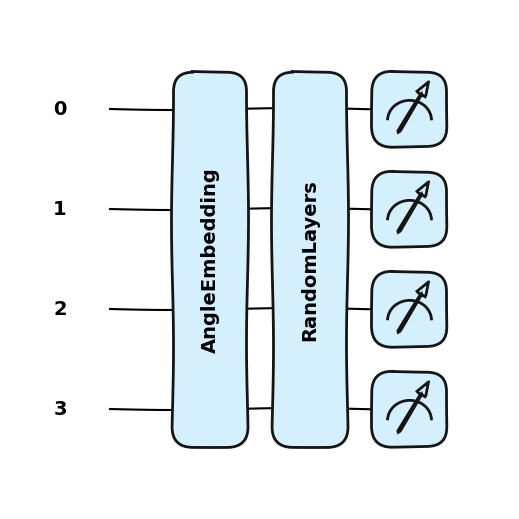

In [53]:
dev1 = qml.device("lightning.gpu", wires = 4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(2, 6))

print(rand_params)
@qml.qnode(dev1, interface='torch', diff_method='adjoint')
def circuit1(inputs, rand_params):
    # Encoding of 4 classical input values
    qml.AngleEmbedding(inputs, wires=list(range(4)), rotation="Y")
    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)), seed = None)

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]


qml.draw_mpl(circuit1, 
             # level=None,
             style = 'pennylane_sketch')(torch.tensor([1,2,3,4]).cuda(), rand_params)

# inputs = torch.rand(64,)
test_layer = qml.qnn.TorchLayer(circuit1, weight_shapes={'rand_params': (n_layers,8)})
circuit1(torch.tensor([[1,2,3,4],[1,2,3,4],[1,2,3,4]]).cuda(),rand_params=rand_params)
# test_layer.rand_params

In [54]:
import torch
from torch import nn 
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn


class QuanvolutionLayer(nn.Module):
    def __init__(self, kernel_size=(2, 2), stride=1, n_filters=1, filter_layers = 1):
        super().__init__()
        self.kernel_size = kernel_size
        self.n_filters = n_filters
        self.num_wires = kernel_size[0] * kernel_size[1]
        self.filter_layer_size = 30 # np.random.randint(4, 2*self.num_wires*torch.floor(torch.log2(torch.tensor(self.num_wires))))
        print(self.filter_layer_size)
        self.filter_seeds = [
            torch.randint(0, int(1e8), (1,)).item() for _ in range(self.n_filters)
        ]
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.q_params = nn.Parameter(torch.randn(n_filters , filter_layers*self.filter_layer_size))
        self.n_rotations_gate = filter_layers*self.filter_layer_size
        self.kernel_h, self.kernel_w = self.kernel_size
        self.stride = stride
    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width)

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, n_filters, new_height, new_width)
        """
        batch_size, channels, height, width = x.shape
        new_height = (height - self.kernel_h) // self.stride + 1
        new_width = (width - self.kernel_w) // self.stride + 1
        epsilon = 1e-8
        # print(new_height, new_width)
        # Prepare output tensor
        output = torch.zeros((batch_size, self.n_filters, new_height, new_width), dtype=torch.float32).to(self.device)
        
        dev = qml.device("lightning.qubit", wires=self.num_wires)
        @qml.qnode(dev,interface='torch', diff_method='best')
        def circuit(inputs, weights, seed = None):
            # Encoding classical inputs
            for j in range(self.num_wires):
                qml.RY(np.pi * inputs[j], wires=j)
        
            # Add random quantum layers
            RandomLayers(weights, 
                         wires=list(range(self.num_wires)),
                         # rotations=[qml.PauliX,qml.PauliY,qml.PauliZ],
                         seed = seed)
                         
        
            # Measurement producing classical outputs
            return [qml.expval(qml.PauliZ(j)) for j in range(self.num_wires)]
        
        for b in range(batch_size):
            # print("CUR BATCH: " + str(b))
            for i in range(0, height - self.kernel_h + 1, self.stride):  # Step by stride
                for j in range(0, width - self.kernel_w + 1, self.stride):  # Step by stride
                    if i + self.kernel_h <= height and j + self.kernel_w <= width:
                        q_out = torch.zeros(self.n_filters, dtype=torch.float32).to(self.device)
                        for c in range(channels):
                            kernel = x[b, c, i:i + self.kernel_h, j:j + self.kernel_w].flatten()
                            # print("kernel: ",kernel.size())
                            kernel = kernel[:self.num_wires]  # Adjust to fit the number of qubits
                            kernel = kernel / torch.max(torch.abs(kernel) + epsilon)  # Normalize
                            for f in range(self.n_filters):
                                quantum_output = torch.sum(torch.hstack(
                                    circuit(inputs = kernel, weights = self.q_params[f].unsqueeze(0), seed = self.filter_seeds[f]))
                                ).float()

                                q_out[f] += quantum_output
                        output[b, :, i // self.stride, j // self.stride] = q_out  # Update with stride indexing
                        # print(output)

        return output

class DynLinear(nn.Module):
    def __init__(self, out_features):
        super().__init__()
        self.out_features = out_features
        self.linear = None  # Placeholder for the Linear layer

    def initialize_linear(self, in_features):
        """Dynamically initialize the Linear layer with the given input size."""
        self.linear = nn.Linear(in_features, self.out_features)
        nn.init.xavier_uniform_(self.linear.weight)
        self.linear.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    def forward(self, x):
        if self.linear is None:
            # Initialize the Linear layer on the first forward pass
            in_features = x.shape[-1]
            self.initialize_linear(in_features)
        return self.linear(x)

# Example Neural Network with Quanvolutional Layer
class QuanvolutionalCNN(nn.Module):
    def __init__(self, model_type = "quantum"):
        super().__init__()
        
        if model_type == "classic":
            self.conv_block = nn.Sequential(
                # nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
                # nn.ReLU(),
                # nn.BatchNorm2d(32),
                # nn.MaxPool2d(2, 2),
                # torch.nn.Dropout(0.5),
                nn.Conv2d(1, 32, 3),
                nn.ReLU(),
                nn.Conv2d(32, 64, 2),
                nn.ReLU(),
                nn.BatchNorm2d(64),
                nn.MaxPool2d(2, 2),
                torch.nn.Dropout(0.3)
            )
        elif model_type == 'quantum':
            self.conv_block = nn.Sequential(
                QuanvolutionLayer(kernel_size=(2,2), n_filters=1, stride=1),
                nn.ReLU(),
                # nn.BatchNorm2d(2),
                nn.MaxPool2d(2, 2),                
                nn.Conv2d(1, 64, 2),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
            )
        else:
            raise ValueError("Invalid model type. Choose either 'classic' or 'quantum'.")
        self.model_type = model_type
        # self.quanv = QuanvolutionLayer(kernel_size=(2, 2), n_filters=3)
        # self.conv  = nn.Conv2d(1, 32,(2,2))
        self.fc = nn.Sequential(
            DynLinear(256),  # Adjust based on quanv output shape
            nn.ReLU(),
            DynLinear(10)   # 10 classes for classification
        )
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        # x = self.quanv(x)
        # if self.model_type == 'quantum':
        #     x = x.cpu() # Somewhat reduce overhead in gpu copy operations when circuit is too small
        
        x = self.conv_block(x)
        
        x = nn.Flatten()(x)  # Flatten
        x = self.fc(x)
        x = self.softmax(x)
        
        return x


class QuanvolutionLayerTest(nn.Module):
    def __init__(self, kernel_size=(2, 2), stride=1, n_filters=1, filter_layers = 1, padding = False):
        super().__init__()
        self.kernel_size = kernel_size
        self.n_filters = n_filters
        self.num_wires = kernel_size[0] * kernel_size[1]
        self.filter_layer_size =  np.random.randint(4, 2*self.num_wires*torch.floor(torch.log2(torch.tensor(self.num_wires))))
        print(self.filter_layer_size)
        
        self.total_wires = self.n_filters * self.num_wires
        self.filter_seeds = torch.randint(0, int(1e8), (1,)).item()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.n_rotations_gate = filter_layers*self.filter_layer_size
        self.kernel_h, self.kernel_w = self.kernel_size
        self.stride = stride
        self.padding = padding
        dev = qml.device("lightning.qubit", wires=self.total_wires)
        @qml.qnode(dev,interface='torch', diff_method='adjoint')
        def circuit(inputs, weights):
            # Encoding classical inputs
            qml.AngleEmbedding(inputs, wires=list(range(0, self.total_wires)), rotation="Y")
        
            # Add random quantum layers
            for i in range(self.n_filters):
                RandomLayers(weights[:,i*self.n_rotations_gate: i*self.n_rotations_gate + self.n_rotations_gate], 
                            wires=list(range(i*self.num_wires, i*self.num_wires + self.num_wires)),
                            # rotations=[qml.PauliX,qml.PauliY,qml.PauliZ],
                            seed = self.filter_seeds+i)
                         
        
            # Measurement producing classical outputs
            measurement = [qml.expval(qml.PauliZ(j)) for j in range(self.total_wires)]
            return measurement
        
        weight_shapes = {"weights": (1,n_filters*filter_layers*self.filter_layer_size)}

        self.kernel_circuits = qml.qnn.TorchLayer(circuit, weight_shapes = weight_shapes)
       
    def circuit_draw(self):
        dummy_output = torch.zeros(self.total_wires)
        print(qml.draw_mpl(self.kernel_circuits, style = 'pennylane_sketch')(dummy_output))    
        
    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width)

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, n_filters, new_height, new_width)
        """
        batch_size, channels, height, width = x.shape
        # print(x.shape)
        new_height = (height - self.kernel_h) // self.stride + 1
        new_width = (width - self.kernel_w) // self.stride + 1
        epsilon = 1e-8

        # Pre-extract patch for efficient computation
        batch_size, channels, height, width = x.shape
        new_height = (height - self.kernel_h) // self.stride + 1
        new_width = (width - self.kernel_w) // self.stride + 1

        # Extract patches
        patches = x.unfold(2, self.kernel_h, self.stride).unfold(3, self.kernel_w, self.stride)
        patches = patches.contiguous().view(batch_size, channels, -1, self.kernel_h * self.kernel_w)
        patches = patches.permute(0, 2, 1, 3)  # Shape: (batch_size, n_patches, channels, kernel_size)
        patches = patches.flatten(2)  # Flatten channels and kernel dimensions
        patches = patches / (torch.max(torch.abs(patches), dim=-1, keepdim=True).values + epsilon)

        # Repeat patches for each quantum filter
        patches = patches.repeat(1, 1, self.n_filters).view(-1, self.n_filters * self.num_wires)

        # Process with quantum circuit
        quantum_outputs = torch.zeros(patches.size(0), self.n_filters*self.num_wires)
        
        # Process the patch through the quantum circuit
        quantum_output = self.kernel_circuits(patches) 
        quantum_output = quantum_output.view(patches.size(0), self.n_filters, self.num_wires).sum(dim=-1)
        quantum_output = quantum_output.view(batch_size, channels, new_height, new_width, self.n_filters).sum(dim=1) 
        output = quantum_output.permute(0,3,1,2) 
        return output

In [55]:
imag, cls = next(iter(train_loader))   

quanv_1 = QuanvolutionLayer(kernel_size=(2, 2), n_filters=3, stride = 2)
quanv_2 = QuanvolutionLayerTest(kernel_size=(2, 2), n_filters=3, stride = 2)
# quanv.circuit_draw()
outputs = quanv_2(imag.unsqueeze(1)[:8])
print("Model output:",  outputs.size())
# print(model._modules['0'].kernel_circuits.ht)



30
13
Model output: torch.Size([8, 3, 14, 14])


In [57]:
%%time
outputs = quanv_1(imag.unsqueeze(1).cuda())
print("Model output:",  outputs.size())

KeyboardInterrupt: 

In [41]:
%%time
outputs = quanv_2(imag.unsqueeze(1))
print("Model output:",  outputs.size())

Model output: torch.Size([64, 3, 14, 14])
CPU times: user 3min 34s, sys: 1.63 s, total: 3min 36s
Wall time: 31.9 s


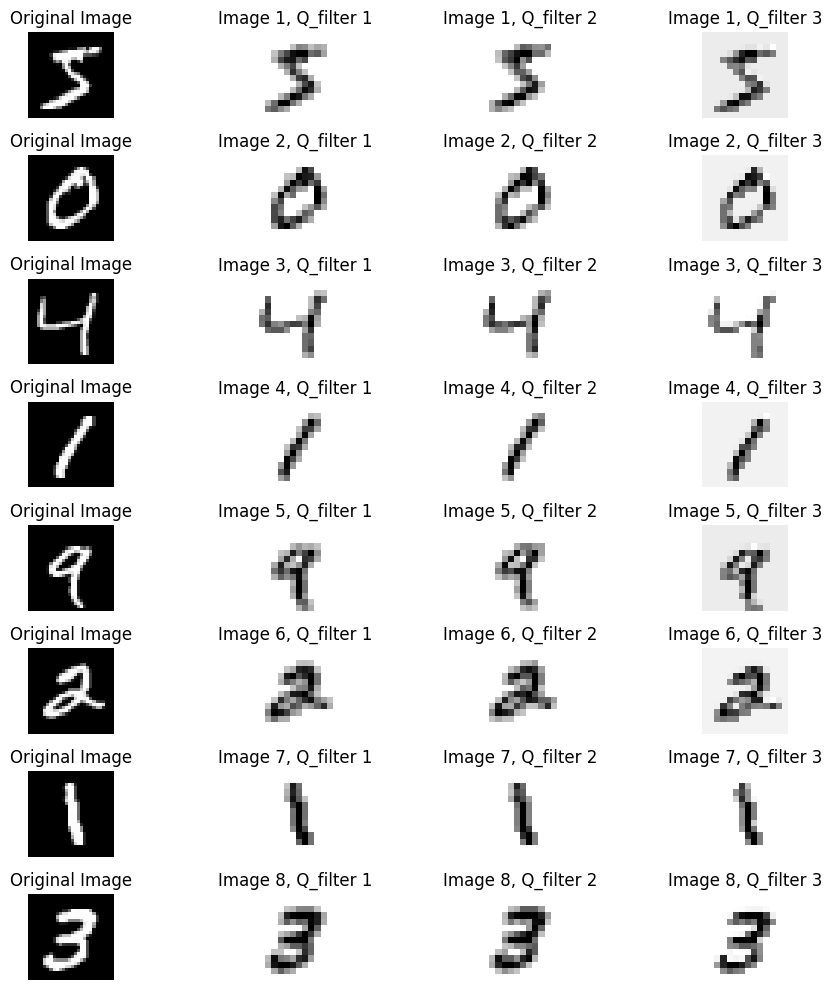

In [45]:
# imag, cls
import torch
import matplotlib.pyplot as plt

# Generate a random tensor to simulate the model output
model_output = outputs[:8]
c, r, _, _ = model_output.size()
# Set up the figure
fig, axes = plt.subplots(c, r+1, figsize=(10, 10))

# Loop through the images in the batch and display them
for batch_idx in range(c):
    ax = axes[batch_idx, 0]
    ax.imshow(imag[batch_idx].cpu().detach().numpy(), cmap='gray')
    ax.axis('off')  # Turn off axis
    ax.set_title(f"Original Image")
    for channel_idx in range(r):
        ax = axes[batch_idx, channel_idx+1]
        ax.imshow(model_output[batch_idx,channel_idx].cpu().detach().numpy(), cmap='gray')
        ax.axis('off')  # Turn off axis
        ax.set_title(f"Image {batch_idx+1}, Q_filter {channel_idx+1}")

# Adjust layout
plt.tight_layout()
plt.show()

In [20]:
import time
kernel_sizes = [(2, 2),(3,3)]
results = []
n_filters_list = [1,2,3]
strides = [2]
input_shape = (1, 1, 28, 28)  
for kernel_size in kernel_sizes:
    for n_filters in n_filters_list:
        if kernel_size == (3,3) and n_filters == 3: break
        for stride in strides:
            # Create input data
            input_data,_ = next(iter(train_loader))
            quanv = nn.Sequential(QuanvolutionLayerTest(kernel_size, stride,n_filters), nn.Flatten(), DynLinear(10)).cuda()
            input_data = input_data.unsqueeze(1)
            # Forward pass timing
            start_time = time.time()
            output = quanv(input_data)
            forward_time = time.time() - start_time
            print(forward_time)
            # Backward pass timing
            loss = output.sum()  # Dummy loss
            start_time = time.time()
            loss.backward()
            backward_time = time.time() - start_time

            # Record results
            results.append({
                'kernel_size': kernel_size,
                'n_filters': n_filters,
                'stride': stride,
                'forward_time': forward_time,
                'backward_time': backward_time
            })
            print(results)
results

30
1.5148704051971436
[{'kernel_size': (2, 2), 'n_filters': 1, 'stride': 2, 'forward_time': 1.5148704051971436, 'backward_time': 0.13637733459472656}]
30
2.941291332244873
[{'kernel_size': (2, 2), 'n_filters': 1, 'stride': 2, 'forward_time': 1.5148704051971436, 'backward_time': 0.13637733459472656}, {'kernel_size': (2, 2), 'n_filters': 2, 'stride': 2, 'forward_time': 2.941291332244873, 'backward_time': 0.25126099586486816}]
30
6.469769477844238
[{'kernel_size': (2, 2), 'n_filters': 1, 'stride': 2, 'forward_time': 1.5148704051971436, 'backward_time': 0.13637733459472656}, {'kernel_size': (2, 2), 'n_filters': 2, 'stride': 2, 'forward_time': 2.941291332244873, 'backward_time': 0.25126099586486816}, {'kernel_size': (2, 2), 'n_filters': 3, 'stride': 2, 'forward_time': 6.469769477844238, 'backward_time': 0.5164661407470703}]
30
1.6934702396392822
[{'kernel_size': (2, 2), 'n_filters': 1, 'stride': 2, 'forward_time': 1.5148704051971436, 'backward_time': 0.13637733459472656}, {'kernel_size': (2

KeyboardInterrupt: 

In [11]:
import time
kernel_sizes = [(2, 2),(3,3)]
results1 = []
n_filters_list = [1,2,3]
strides = [2]
input_shape = (1, 1, 28, 28)  
for kernel_size in kernel_sizes:
    for n_filters in n_filters_list:
        for stride in strides:
            # Create input data
            input_data = torch.randn(input_shape, requires_grad=False)
            quanv = QuanvolutionLayer(kernel_size, stride, n_filters)
            
            # Forward pass timing
            start_time = time.time()
            output = quanv(input_data)
            forward_time = time.time() - start_time
            print(forward_time)
            # Backward pass timing
            loss = output.sum()  # Dummy loss
            start_time = time.time()
            loss.backward()
            backward_time = time.time() - start_time

            # Record results
            results1.append({
                'kernel_size': kernel_size,
                'n_filters': n_filters,
                'stride': stride,
                'forward_time': forward_time,
                'backward_time': backward_time
            })
            print(results1)
results1

30
CUR BATCH: 0
1.9411330223083496
[{'kernel_size': (2, 2), 'n_filters': 1, 'stride': 2, 'forward_time': 1.9411330223083496, 'backward_time': 0.17618727684020996}]
30
CUR BATCH: 0
3.3810226917266846
[{'kernel_size': (2, 2), 'n_filters': 1, 'stride': 2, 'forward_time': 1.9411330223083496, 'backward_time': 0.17618727684020996}, {'kernel_size': (2, 2), 'n_filters': 2, 'stride': 2, 'forward_time': 3.3810226917266846, 'backward_time': 0.29895949363708496}]
30
CUR BATCH: 0
4.722832202911377
[{'kernel_size': (2, 2), 'n_filters': 1, 'stride': 2, 'forward_time': 1.9411330223083496, 'backward_time': 0.17618727684020996}, {'kernel_size': (2, 2), 'n_filters': 2, 'stride': 2, 'forward_time': 3.3810226917266846, 'backward_time': 0.29895949363708496}, {'kernel_size': (2, 2), 'n_filters': 3, 'stride': 2, 'forward_time': 4.722832202911377, 'backward_time': 0.3886849880218506}]
30
CUR BATCH: 0
1.8437068462371826
[{'kernel_size': (2, 2), 'n_filters': 1, 'stride': 2, 'forward_time': 1.9411330223083496, 'b

[{'kernel_size': (2, 2),
  'n_filters': 1,
  'stride': 2,
  'forward_time': 1.9411330223083496,
  'backward_time': 0.17618727684020996},
 {'kernel_size': (2, 2),
  'n_filters': 2,
  'stride': 2,
  'forward_time': 3.3810226917266846,
  'backward_time': 0.29895949363708496},
 {'kernel_size': (2, 2),
  'n_filters': 3,
  'stride': 2,
  'forward_time': 4.722832202911377,
  'backward_time': 0.3886849880218506},
 {'kernel_size': (3, 3),
  'n_filters': 1,
  'stride': 2,
  'forward_time': 1.8437068462371826,
  'backward_time': 0.17560625076293945},
 {'kernel_size': (3, 3),
  'n_filters': 2,
  'stride': 2,
  'forward_time': 3.302899122238159,
  'backward_time': 0.2781071662902832},
 {'kernel_size': (3, 3),
  'n_filters': 3,
  'stride': 2,
  'forward_time': 4.729715347290039,
  'backward_time': 0.3879587650299072}]

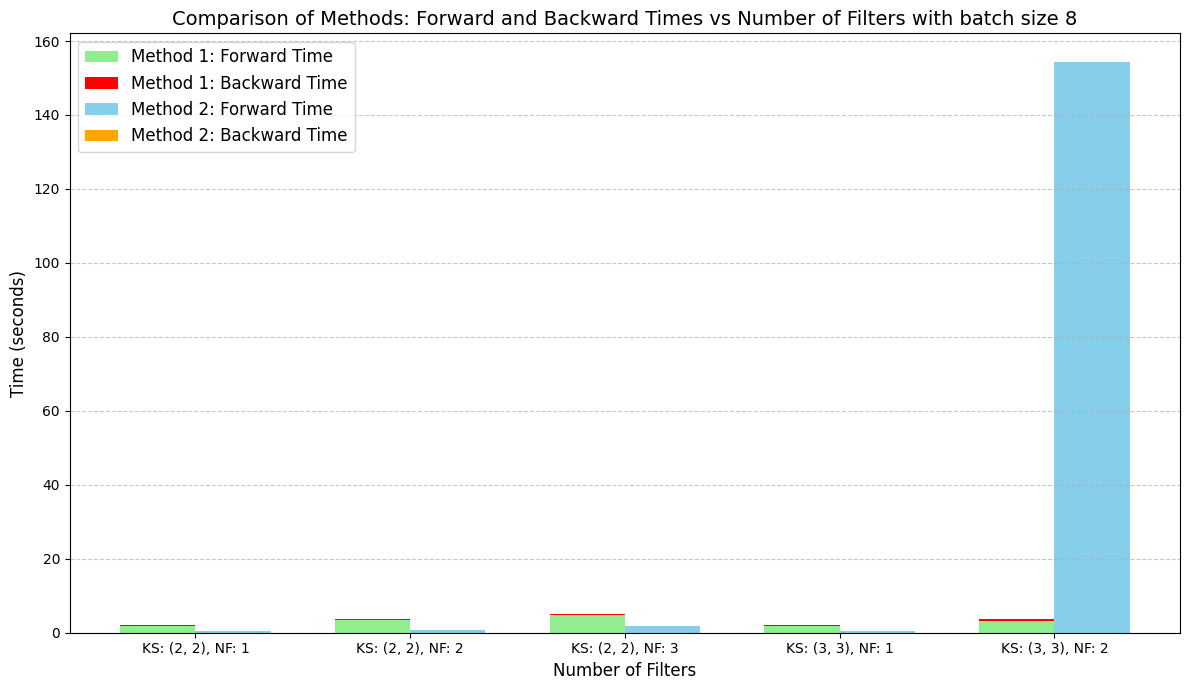

In [13]:
# Extract parameters and times
labels = [f"KS: {res['kernel_size']}, NF: {res['n_filters']}" for res in results]
forward_times = [res['forward_time'] for res in results]
backward_times = [res['backward_time'] for res in results]

forward_times1 = [res['forward_time'] for res in results1[:len(results)]]
backward_times1 = [res['backward_time'] for res in results1[:len(results)]]

# Bar width and positions
bar_width = 0.35
x = np.arange(len(labels))  # x positions for bars

# Plot stacked bars for both methods
plt.figure(figsize=(12, 7))
plt.bar(x - bar_width / 2, forward_times1, bar_width, label='Method 1: Forward Time', color='lightgreen')
plt.bar(x - bar_width / 2, backward_times1, bar_width, bottom=forward_times1, label='Method 1: Backward Time', color='red')

plt.bar(x + bar_width / 2, forward_times, bar_width, label='Method 2: Forward Time', color='skyblue')
plt.bar(x + bar_width / 2, backward_times, bar_width, bottom=forward_times, label='Method 2: Backward Time', color='orange')

# Formatting the plot
plt.title("Comparison of Methods: Forward and Backward Times vs Number of Filters with batch size 8", fontsize=14)
plt.xlabel("Number of Filters", fontsize=12)
plt.ylabel("Time (seconds)", fontsize=12)
plt.xticks(x, labels, fontsize=10)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()


In [55]:
from torcheval.metrics import MulticlassAccuracy
from torcheval.metrics.functional import multiclass_accuracy


In [69]:
model = QuanvolutionalCNN(model_type = 'classic').to(torch.device('cuda'))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
logging_steps = 100

metric = MulticlassAccuracy()
losses = np.array([])
accs = np.array([])
global_step = 0
for epoch in range(10):
    
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.unsqueeze(1).cuda()
        # print(images.size(), images.unsqueeze(1).size())
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images).cpu()  # Forward pass
        # print(outputs, labels)
        loss = criterion(outputs, labels)  
        loss.backward()
        optimizer.step()
        
        # output
        acc = multiclass_accuracy(outputs, labels)
        
        metric.update(outputs, labels)
        losses = np.append(losses, loss.item())
        global_step += 1
        if global_step % logging_steps == 0:
            print("Epoch:", epoch+1, 
                "\tStep:", global_step, 
                # "\tAcc:", round(float(acc), 3), 
                "\tLoss:", round(loss.item(),3),
                "\tMean Loss:", round(float(losses[-30:].mean()), 3),
                "\tMean Acc:", round(float(metric.compute()), 3)
                )
        # break

        # losses = np.append(losses, loss.item())

        # print("After update:", model.quanv.q_params.grad)
        # print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


Epoch: 1 	Step: 100 	Loss: 2.105 	Mean Loss: 1.954 	Mean Acc: 0.363
Epoch: 1 	Step: 200 	Loss: 1.77 	Mean Loss: 1.891 	Mean Acc: 0.474
Epoch: 1 	Step: 300 	Loss: 1.795 	Mean Loss: 1.816 	Mean Acc: 0.541
Epoch: 1 	Step: 400 	Loss: 1.777 	Mean Loss: 1.792 	Mean Acc: 0.576
Epoch: 1 	Step: 500 	Loss: 2.12 	Mean Loss: 1.776 	Mean Acc: 0.61
Epoch: 1 	Step: 600 	Loss: 1.594 	Mean Loss: 1.739 	Mean Acc: 0.632
Epoch: 1 	Step: 700 	Loss: 1.913 	Mean Loss: 1.721 	Mean Acc: 0.646
Epoch: 1 	Step: 800 	Loss: 1.6 	Mean Loss: 1.704 	Mean Acc: 0.66
Epoch: 1 	Step: 900 	Loss: 1.735 	Mean Loss: 1.748 	Mean Acc: 0.673
Epoch: 1 	Step: 1000 	Loss: 1.705 	Mean Loss: 1.724 	Mean Acc: 0.684
Epoch: 1 	Step: 1100 	Loss: 1.704 	Mean Loss: 1.699 	Mean Acc: 0.692
Epoch: 1 	Step: 1200 	Loss: 1.526 	Mean Loss: 1.692 	Mean Acc: 0.7


KeyboardInterrupt: 

In [ ]:
model = QuanvolutionalCNN(model_type = 'quantum').cuda()
print(model)

In [ ]:

import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
logging_steps = 1
# from sklearn.metrics import accuracy_score

metric = MulticlassAccuracy()
losses = np.array([])
accs = np.array([])
global_step = 0
for epoch in range(10):
    
    for i, (images, labels) in enumerate(train_loader):
        
        images = F.pad(images,(1,1,1,1)).unsqueeze(1).cuda()
        print(images.size())
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images).cpu()  # Forward pass
        # print(outputs, labels)
        loss = criterion(outputs, labels)  
        loss.backward()
        optimizer.step()
        
        # output
        acc = multiclass_accuracy(outputs, labels)
        
        metric.update(outputs, labels)
        losses = np.append(losses, loss.item())
        global_step += 1
        if global_step % logging_steps == 0:
            print("Epoch:", epoch+1, 
                "\tStep:", global_step, 
                # "\tAcc:", round(float(acc), 3), 
                "\tLoss:", round(loss.item(),3),
                "\tMean Loss:", round(float(losses[-30:].mean()), 3),
                "\tMean Acc:", round(float(metric.compute()), 3)
                )
        # break

torch.Size([8, 1, 30, 30])


In [ ]:
torch.save(model, './quanv-99-f.pt')
d = torch.load('./quanv-99-f.pt', weights_only=False)
d

In [61]:
losses

tensor([2.29928541, 2.26646066, 2.31143808, 2.28566694, 2.30074406,
        2.23117399, 2.29665089, 2.28838134, 2.29740858, 2.3180263 ,
        2.27688241, 2.2809937 , 2.27192926, 2.26544619, 2.26576376,
        2.29138565, 2.28762531, 2.30460477, 2.30582309, 2.29767585,
        2.30524755, 2.29540229, 2.27753139, 2.31416941, 2.32026243,
        2.33729196, 2.30120635, 2.27086878, 2.29895782, 2.32046843,
        2.31096268, 2.26653194, 2.29952621, 2.30972648, 2.31481028,
        2.29856586, 2.32582045, 2.30594182, 2.28059483, 2.29702687,
        2.27705717, 2.25737238, 2.2603631 , 2.33293843, 2.29739237,
        2.28674936, 2.34554625, 2.32904792, 2.29863691, 2.33484936,
        2.29960442, 2.30133915, 2.26774311, 2.35196757, 2.30750084,
        2.32060337, 2.23556137, 2.32819748, 2.33270621, 2.32574701,
        2.31356645, 2.30300641, 2.29785919, 2.31536317, 2.32911825,
        2.32489777, 2.17661834, 2.29007792, 2.31942916, 2.33761501,
        2.23471022, 2.31688023, 2.31395173, 2.29

In [52]:

print(model.conv_block._modules['0'].q_params)
print(model.conv_block._modules['5'].q_params)
optimizer.zero_grad()
outputs = model(images[:4]).cpu()  # Forward pass


loss = criterion(outputs, labels[:4])  
loss.backward()
optimizer.step()
print(model.conv_block._modules['0'].q_params.grad)
print(model.conv_block._modules['5'].q_params)


Parameter containing:
tensor([[-0.3412,  0.0390, -0.1892,  0.1028, -0.6929, -0.3718, -0.9820, -0.4704,
         -0.4137, -1.5197, -0.1858,  1.6441,  0.2530],
        [ 0.1813, -0.9602, -0.0967, -1.1668, -1.0073,  0.6101, -0.0489, -1.5478,
          0.0143, -0.5811, -1.0953,  0.2186, -1.3174]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[ 0.2370,  0.5141,  0.3099,  0.8612,  0.1464, -1.5052,  1.1392,  0.0544,
         -0.5161, -1.1758,  1.1639,  0.6922, -2.2416],
        [ 0.0764,  0.6981,  1.4979,  0.7481, -0.3796,  0.4404,  1.9963,  0.9300,
          0.7086, -1.2239,  0.2791, -1.5128,  0.4267]], device='cuda:0',
       requires_grad=True)
13 13
CUR BATCH: 0
CUR BATCH: 1
CUR BATCH: 2
CUR BATCH: 3
3 3
CUR BATCH: 0
CUR BATCH: 1
CUR BATCH: 2
CUR BATCH: 3
tensor([[-1.1553e-19,  5.5524e-05,  2.1918e-04, -9.8588e-04, -3.8794e-05,
         -3.3907e-20, -4.8771e-04, -6.1539e-04, -4.5283e-04, -1.3964e-05,
          1.3151e-19, -7.8229e-04,  2.9520e-04],
        [ 5

In [2]:
import pennylane as qml
qml

<module 'pennylane' (<_frozen_importlib_external.NamespaceLoader object at 0x7efdb3f1de90>)>

In [45]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14,4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for i in range(4):
      cir = circuit1
      for j in range(0, 28, 2):
          for k in range(0, 28, 2):
              # Process a squared 2x2 region of the image with a quantum circuit
              # print(j, k )
              q_results = cir(
                  [
                      image[0,j, k],
                      image[0,j, k + 1],
                      image[0,j + 1, k],
                      image[0,j + 1, k + 1]
                  ]
              )
              # Assign expectation values to different channels of the output pixel (j/2, k/2)
              # print(q_results)
                  # out[j // 2, k // 2, c] = q_results[c]
              for c in range(4):
                # print(out[i, j // 2, k // 2], q_results[c])
                out[j // 2, k // 2,c] += q_results[c].float().numpy()
              # out[j // 2, k // 2, i] /= 4
    return out

# Quantum pre-processing of the dataset

Since we are not going to train the quantum convolution layer, it is
more efficient to apply it as a \"pre-processing\" layer to all the
images of our dataset. Later an entirely classical model will be
directly trained and tested on the pre-processed dataset, avoiding
unnecessary repetitions of quantum computations.

The pre-processed images will be saved in the folder `SAVE_PATH`. Once
saved, they can be directly loaded by setting `PREPROCESS = False`,
otherwise the quantum convolution is evaluated at each run of the code.



In [41]:
import os
os.environ["OMP_NUM_THREADS"] = "16"  # Replace 4 with your desired number of threads


In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, (img, _) in enumerate(train_loader):
        # print(img.size())
        if idx >=5: break
        print("\r{}/{}".format(idx + 1, n_train), end = '')
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("\r{}/{}".format(idx + 1, n_test), end = '')
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # # Save pre-processed images
    # np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    # np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# # Load pre-processed images
# q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
# q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
1/50

/home/paultran27/miniconda3/envs/pnl/lib/python3.11/site-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


5/50
Quantum pre-processing of test images:


NameError: name 'test_images' is not defined

Let us visualize the effect of the quantum convolution layer on a batch
of samples:


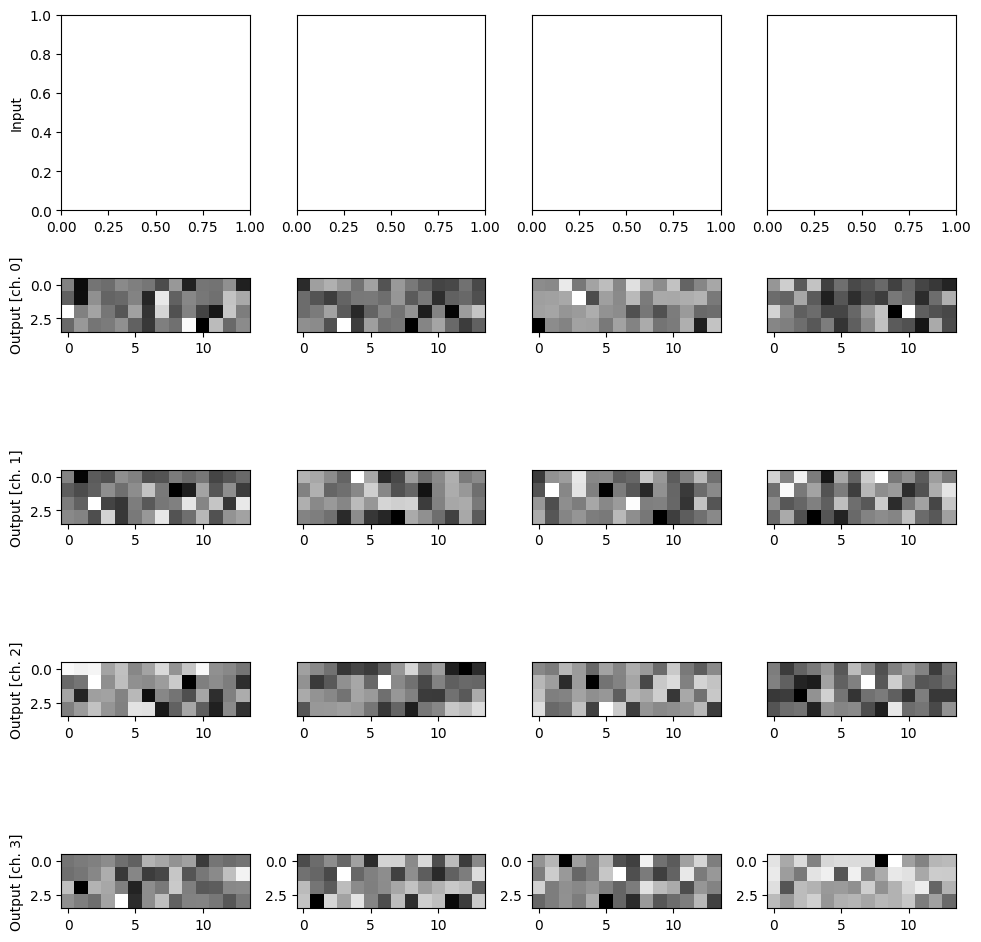

In [44]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    # axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

Below each input image, the $4$ output channels generated by the quantum
convolution are visualized in gray scale.

One can clearly notice the downsampling of the resolution and some local
distortion introduced by the quantum kernel. On the other hand the
global shape of the image is preserved, as expected for a convolution
layer.


# Hybrid quantum-classical model

After the application of the quantum convolution layer we feed the
resulting features into a classical neural network that will be trained
to classify the $10$ different digits of the MNIST dataset.

We use a very simple model: just a fully connected layer with 10 output
nodes with a final *softmax* activation function.

The model is compiled with a *stochastic-gradient-descent* optimizer,
and a *cross-entropy* loss function.


In [100]:
train_images.shape

NameError: name 'train_images' is not defined

In [50]:

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

def ClassicModel():
    """Initializes and returns a custom Keras CNN model ready to be trained on MNIST."""
    model = keras.models.Sequential([
        # First Convolutional layer
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

def QuanvModel():
    """Initializes and returns a custom Keras CNN model ready to be trained on MNIST."""
    model = keras.models.Sequential([
        # First Convolutional layer
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(14, 14, 4)),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model



# Training

We first initialize an instance of the model, then we train and validate
it with the dataset that has been already pre-processed by a quantum
convolution.


In [9]:
import tqdm

In [12]:
q_train_images = []
q_test_images  = []
quanv = QuanvolutionLayerTest((2,2),2,2)
train_iter = iter(train_loader)
for _ in tqdm.tqdm(range(1000)):
    img, cls  = next(train_iter)
    img = img.unsqueeze(1)
    q_features = quanv(img)
    q_train_images.append(q_features)
    # break

12


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:25<00:00,  2.59it/s]


In [32]:
q_train_images = torch.load("QuanvProcessed.pt")
q_train_images[0].size()

/tmp/ipykernel_15068/3472159198.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  q_train_images = torch.load("QuanvProcessed.pt")


torch.Size([1, 2, 14, 14])

In [33]:
train_iter = iter(train_loader)
for i in tqdm.tqdm(range(1000)):
    img, cls  = next(train_iter)
    q_train_images[i] =  (q_train_images[i], cls[0])

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10530.99it/s]


In [34]:
q_train_images[0]

(tensor([[[[ 0.1932,  0.1932,  0.1932,  0.1932,  0.1932,  0.1932,  0.1932,
             0.1932,  0.1932,  0.1932,  0.1932,  0.1932,  0.1932,  0.1932],
           [ 0.1932,  0.1932,  0.1932,  0.1932,  0.1932,  0.1932,  0.1932,
             0.1932,  0.1932,  0.1932,  0.1932,  0.1932,  0.1932,  0.1932],
           [ 0.1932,  0.1932,  0.1932,  0.1932,  0.1932,  0.1932, -0.4236,
            -0.3479, -0.3581,  0.1806, -0.3912, -0.0576,  0.1932,  0.1932],
           [ 0.1932,  0.1932,  0.1932, -0.4259, -0.4508, -0.6536, -0.8627,
            -0.9313, -0.9273, -0.5756, -0.5177, -0.1344,  0.1932,  0.1932],
           [ 0.1932,  0.1932,  0.1932, -0.0753, -0.8451, -1.1014, -0.8233,
            -0.3152, -0.8881,  0.1932,  0.1932,  0.1932,  0.1932,  0.1932],
           [ 0.1932,  0.1932,  0.1932,  0.1932, -0.0753, -0.6467, -0.6749,
             0.2741,  0.1932,  0.1932,  0.1932,  0.1932,  0.1932,  0.1932],
           [ 0.1932,  0.1932,  0.1932,  0.1932,  0.1932, -0.0753, -1.0663,
            -0.3680

In [21]:
torch.save(q_train_images,"QuanvProcessed.pt")

In [35]:
torch.save(q_train_images,"QuanvProcessedWithLabels.pt")

In [66]:

from torch.utils.data import Dataset, DataLoader

class TensorLabelDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tensor, label = self.data[idx]
        return tensor, label

# Create dataset
dataset = TensorLabelDataset(q_train_images)
# Create dataset
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [67]:
from torcheval.metrics import MulticlassAccuracy
from torcheval.metrics.functional import multiclass_accuracy


In [79]:
model = QuanvolutionalCNN(model_type = 'classic').to(torch.device('cuda'))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
logging_steps = 100

metric = MulticlassAccuracy()
losses = np.array([])
accs = np.array([])
global_step = 0
for epoch in range(200):
    
    for i, (images, labels) in enumerate(dataloader):
        
        images = images.squeeze(1).cuda()
        # print(images.size(), images.unsqueeze(1).size())
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images).cpu()  # Forward pass
        # print(outputs, labels)
        loss = criterion(outputs, labels)  
        loss.backward()
        optimizer.step()
        
        # output
        acc = multiclass_accuracy(outputs, labels)
        
        metric.update(outputs, labels)
        losses = np.append(losses, loss.item())
        global_step += 1
        if global_step % logging_steps == 0:
            print("Epoch:", epoch+1, 
                "\tStep:", global_step, 
                "\tAcc:", round(float(acc), 3), 
                "\tLoss:", round(loss.item(),3),
                "\tMean Loss:", round(float(losses[-30:].mean()), 3),
                "\tMean Acc:", round(float(metric.compute()), 3)
                )
        # break

        # losses = np.append(losses, loss.item())

        # print("After update:", model.quanv.q_params.grad)
        # print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


Epoch: 7 	Step: 100 	Acc: 0.703 	Loss: 1.813 	Mean Loss: 1.842 	Mean Acc: 0.545
Epoch: 13 	Step: 200 	Acc: 0.75 	Loss: 1.721 	Mean Loss: 1.711 	Mean Acc: 0.648
Epoch: 19 	Step: 300 	Acc: 0.828 	Loss: 1.653 	Mean Loss: 1.674 	Mean Acc: 0.699
Epoch: 25 	Step: 400 	Acc: 0.75 	Loss: 1.734 	Mean Loss: 1.651 	Mean Acc: 0.729
Epoch: 32 	Step: 500 	Acc: 0.859 	Loss: 1.632 	Mean Loss: 1.647 	Mean Acc: 0.749
Epoch: 38 	Step: 600 	Acc: 0.922 	Loss: 1.545 	Mean Loss: 1.614 	Mean Acc: 0.766
Epoch: 44 	Step: 700 	Acc: 0.875 	Loss: 1.59 	Mean Loss: 1.622 	Mean Acc: 0.778
Epoch: 50 	Step: 800 	Acc: 0.9 	Loss: 1.583 	Mean Loss: 1.613 	Mean Acc: 0.788
Epoch: 57 	Step: 900 	Acc: 0.891 	Loss: 1.58 	Mean Loss: 1.601 	Mean Acc: 0.797
Epoch: 63 	Step: 1000 	Acc: 0.859 	Loss: 1.623 	Mean Loss: 1.605 	Mean Acc: 0.804
Epoch: 69 	Step: 1100 	Acc: 0.828 	Loss: 1.66 	Mean Loss: 1.595 	Mean Acc: 0.81
Epoch: 75 	Step: 1200 	Acc: 0.85 	Loss: 1.61 	Mean Loss: 1.592 	Mean Acc: 0.816
Epoch: 82 	Step: 1300 	Acc: 0.891 	L

In [84]:
model = QuanvolutionalCNN(model_type = 'classic').to(torch.device('cuda'))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
logging_steps = 100

metric = MulticlassAccuracy()
losses = np.array([])
accs = np.array([])
global_step = 0
for epoch in range(200):
    j = 0    
    train_iter = iter(train_loader)

    for i in range(1000//64):
        images, labels = next(train_iter)
        images = images.unsqueeze(1).cuda()
        # print(images.size(), images.unsqueeze(1).size())
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images).cpu()  # Forward pass
        # print(outputs, labels)
        loss = criterion(outputs, labels)  
        loss.backward()
        optimizer.step()
        
        # output
        acc = multiclass_accuracy(outputs, labels)
        
        metric.update(outputs, labels)
        losses = np.append(losses, loss.item())
        global_step += 1
        if global_step % logging_steps == 0:
            print("Epoch:", epoch+1, 
                "\tStep:", global_step, 
                "\tAcc:", round(float(acc), 3), 
                "\tLoss:", round(loss.item(),3),
                "\tMean Loss:", round(float(losses[-30:].mean()), 3),
                "\tMean Acc:", round(float(metric.compute()), 3)
                )
        # break

        # losses = np.append(losses, loss.item())

        # print("After update:", model.quanv.q_params.grad)
        # print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


Epoch: 7 	Step: 100 	Acc: 0.547 	Loss: 1.954 	Mean Loss: 1.9 	Mean Acc: 0.492
Epoch: 14 	Step: 200 	Acc: 0.688 	Loss: 1.791 	Mean Loss: 1.768 	Mean Acc: 0.601
Epoch: 20 	Step: 300 	Acc: 0.719 	Loss: 1.769 	Mean Loss: 1.711 	Mean Acc: 0.656
Epoch: 27 	Step: 400 	Acc: 0.812 	Loss: 1.721 	Mean Loss: 1.688 	Mean Acc: 0.691
Epoch: 34 	Step: 500 	Acc: 0.766 	Loss: 1.711 	Mean Loss: 1.667 	Mean Acc: 0.716
Epoch: 40 	Step: 600 	Acc: 0.812 	Loss: 1.677 	Mean Loss: 1.637 	Mean Acc: 0.735
Epoch: 47 	Step: 700 	Acc: 0.828 	Loss: 1.655 	Mean Loss: 1.62 	Mean Acc: 0.752
Epoch: 54 	Step: 800 	Acc: 0.844 	Loss: 1.622 	Mean Loss: 1.599 	Mean Acc: 0.768
Epoch: 60 	Step: 900 	Acc: 0.844 	Loss: 1.64 	Mean Loss: 1.597 	Mean Acc: 0.78
Epoch: 67 	Step: 1000 	Acc: 0.938 	Loss: 1.563 	Mean Loss: 1.578 	Mean Acc: 0.791
Epoch: 74 	Step: 1100 	Acc: 0.906 	Loss: 1.578 	Mean Loss: 1.576 	Mean Acc: 0.802
Epoch: 80 	Step: 1200 	Acc: 0.922 	Loss: 1.564 	Mean Loss: 1.561 	Mean Acc: 0.811
Epoch: 87 	Step: 1300 	Acc: 0.9

/tmp/ipykernel_55/1108332421.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.tensor(torch.load(file_path))


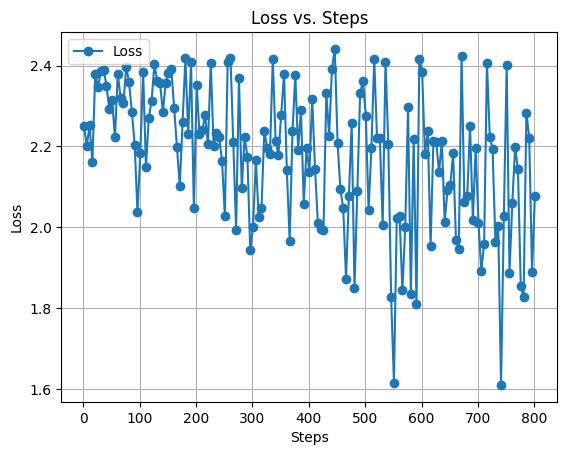

In [17]:
import torch
import matplotlib.pyplot as plt

# Load the tensor from the .pt file
file_path = "model_loss.pt"  # Replace with your actual file path
data = torch.tensor(torch.load(file_path))
# print(torch.tensor(data).size())

# Assuming the data is a 1D tensor with loss values for each epoch
if isinstance(data, torch.Tensor) and data.ndim == 1:
    epochs = range(1, len(data) + 1,5)
    plt.plot(epochs, data.numpy()[::5], marker='o', label="Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Loss vs. Steps")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("The loaded data is not a 1D tensor. Please check the .pt file structure.")


# Results

We can finally plot the test accuracy and the test loss with respect to
the number of training epochs.


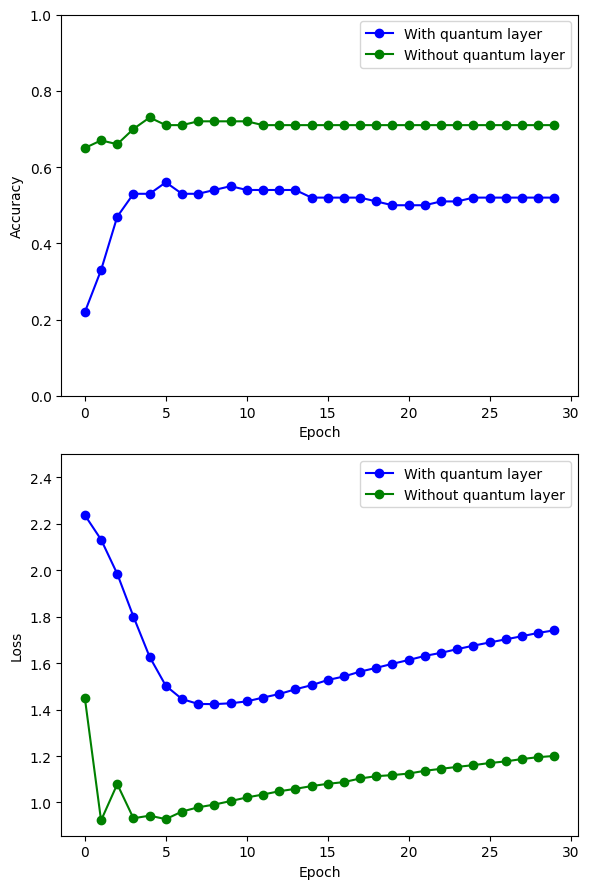

In [25]:
import matplotlib.pyplot as plt

# plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

# References

1.  Maxwell Henderson, Samriddhi Shakya, Shashindra Pradhan, Tristan
    Cook. \"Quanvolutional Neural Networks: Powering Image Recognition
    with Quantum Circuits.\"
    [arXiv:1904.04767](https://arxiv.org/abs/1904.04767), 2019.

# About the author
